In [1]:
#Script to evaluate the determinants of patent citation 
#Renato Kogeyama
# Jan 21, 2020
# Classifications added
# Code reorganized - much faster now
# Still missing the update of applications to the grant number
# I should provide now descriptive statistics on all variables

# Jan 21, 2020
# The current data does not have Class
# I should go back and get this info - but there are too many scripts now and
#   I should reorganize them before moving forward
# I should also include the patent publication date - to control for the policy changes
# In the citation file, I should change application number for grant when possible 
#   This will improve realiability of all measures related to citation
# Introduce classifications

# Jan 18, 2020
# Variables calculated
# Generality, average delay, forward and backward citations, cumulative citation (cit_tree)
# Still missing originality
# the file with variables that are used in this script should get a name independent from the date


#Miami, December 24th, 2019
# Prof. Rafael Corredoira suggested:
# - Inclusion of a tree of citations
#   To track back the source of citations. This is information is not given by direct count of citations.
# - Consider policy changes in the way patents are cited
#   Policy changes in 2000 changed the time frame of citation, and 2010 partially moved citation to applications
# - Track classification changes 
#   The original classification system in USPTO changed from a technical based to a market based classification system
#   See if there is an impact
# - Consider a text analysis of the claims
#   Classification is based on the claims but it is not clear how many claims are related to each classification category
# - Include moderation effect from classification
#   Citations patterns may change across industries, so some effects may disappear if industry is not accounted for.

# In summary, his ideas help increase structure of the current work


#Syracuse, December 3rd, 2019

#The original script is getting too complex
#There was many tentative scripts to play with data
#Here I am writing a script to show the relevance of variables to patent citation

#11-12-2019
#Introducing normalization

#10-11-2019
#I introduced log backward citation, what corrects for very dispersed results
#but the major problem is that few patents receive citations
#bring back binary output

#10-10-2019
#Added graphics and new distributions

#10-03-2019
#I rewrote the citation data to clean the strings

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-27-2019
#I am renaming citation as forward citation and backward citation

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 



In [2]:
import pandas as pd
import numpy as np
import IPython.display as display
import seaborn as sns
          
import itertools
import matplotlib


from sklearn import preprocessing
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import naive_bayes
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

import scipy.stats as ss
import datetime
import matplotlib.pyplot as plt
# import pylab as pl

from math import sqrt


import sys
sys.path.append('/home/rkogeyam/scripts/')

from best_num_attr import best_num_attr
from xattrSelect import xattrSelect
from sampler import sampler
from normalize import normalize
from nbayes import nbayes

In [3]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [4]:
%matplotlib inline
sns.set()
sns.set_palette(sns.cubehelix_palette(8))

In [5]:
# dtypes={'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
#        'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
#        'originality':float, 'generality':float, 'wipo_field_id':object, 'ipcr_section':object,
#        'ipcr_ipc_class':object, 'ipcr_subclass':object, 'cpc_section_id':object,
#        'cpc_subsection_id':object, 'cpc_group_id':object, 'nber_category_id':object,
#        'nber_subcategory_id':object, 'uspc_mainclass_id':object, 'uspc_subclass_id':object}

In [6]:
dtypes={'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
       'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
       'originality':float, 'generality':float, 'wipo_field_id':object, 'ipcr_section':object,
       'cpc_section_id':object,'nber_category_id':object,'uspc_mainclass_id':object}

In [7]:
usecols=['id', 'type', 'date', 'kind', 'num_claims', 'cit_received', 'cit_made',
         'cit_received_delay', 'cit_made_delay', 'parent_citation',
         'originality', 'generality', 'wipo_field_id', 'ipcr_section', 
         'cpc_section_id', 'nber_category_id']

In [8]:
dataset='data/dataset.csv'

df=pd.read_csv(dataset, dtype=dtypes, usecols=usecols, parse_dates=['date'], index_col='id')

# sample_size=1000
# df=sampler(fname, sample_size)

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.columns

Index(['type', 'date', 'kind', 'num_claims', 'cit_received', 'cit_made',
       'cit_received_delay', 'cit_made_delay', 'parent_citation',
       'originality', 'generality', 'wipo_field_id', 'ipcr_section',
       'cpc_section_id', 'nber_category_id'],
      dtype='object')

In [10]:
obj_cols=list(df.select_dtypes(include=[object]).columns.values)

In [11]:
# for i in obj_cols:
#     fig, axs=plt.subplots(1,2)
#     plt.title('Total Patents per ' + i)
#     plt.grid(b=True)
#     axs[0]=df.groupby(i).count().iloc[:,2].sort_values(ascending=False).plot(kind='barh')
#     axs[1].axis('tight')
#     axs[1].axis('off')
#     axs[1]=df.groupby(i).count().iloc[:,2].sort_values(ascending=False).values
#     plt.show()
#     print('\n')

In [12]:
for i in obj_cols:
    print(i)
    display.display(df.groupby(i).count().iloc[:,2].sort_values(ascending=False))

type


type
utility                             5879880
design                               563003
plant                                 24790
reissue                               17812
statutory invention registration       2254
defensive publication                   509
TVPP                                      3
Name: num_claims, dtype: int64

kind


kind
B2    2920417
A     2391379
B1     568083
S1     353421
S      209582
P2      11401
E1       9120
E        8692
P        8282
P3       5107
H        1982
I4        509
H1        272
I5          3
H2          3
Name: num_claims, dtype: int64

wipo_field_id


wipo_field_id
6     527598
1     364987
4     309548
8     301519
13    294657
2     280854
10    280786
9     274243
32    247912
14    217916
3     191435
29    179305
31    163157
35    162776
27    161860
33    149362
25    144691
26    141687
23    136182
28    127006
15    125432
19    117271
17    114950
5     111786
34    108371
12     98095
16     96550
20     94245
21     83131
7      66095
24     58618
30     58438
18     38424
11     28743
22     13014
Name: kind, dtype: int64

ipcr_section


ipcr_section
G    1490024
H    1300685
B     941969
A     794813
C     599667
F     447476
D     203350
E     149990
L        179
M        111
N         89
P         86
R         79
K         58
Q         52
2         50
S         48
I         48
1         39
J         28
O         17
T         15
V         11
6          9
Z          8
0          8
4          7
X          5
U          4
3          4
W          4
8          3
5          3
Y          2
9          1
Name: kind, dtype: int64

cpc_section_id


cpc_section_id
G    1451211
H    1405090
B     888609
A     735918
C     690423
F     453127
E     163063
D      64032
Name: kind, dtype: int64

nber_category_id


nber_category_id
2    1203076
4    1047307
5     829653
6     793734
1     731273
3     485950
7        268
Name: kind, dtype: int64

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


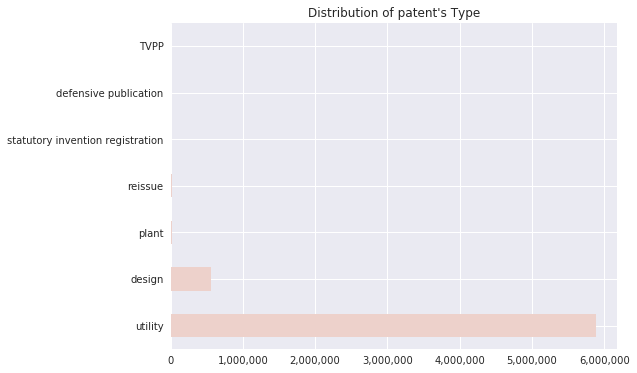

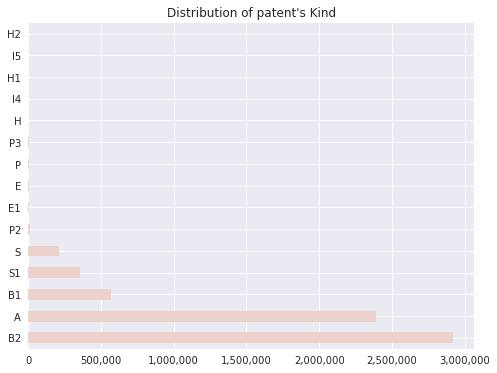

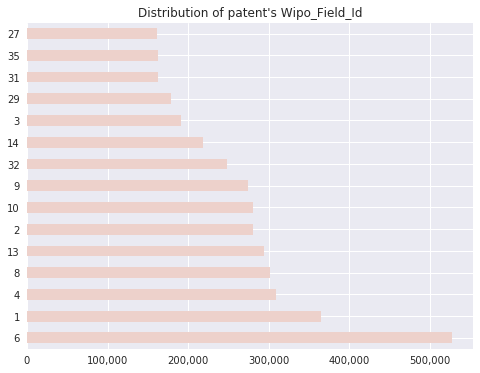

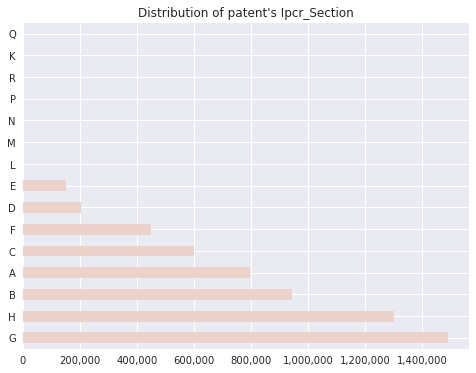

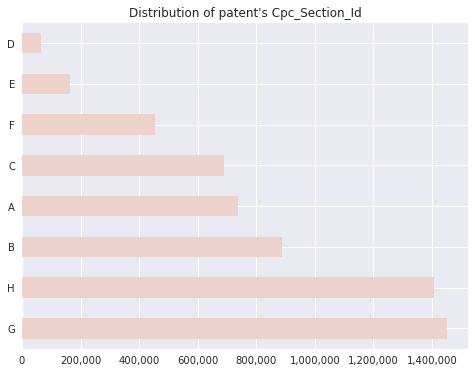

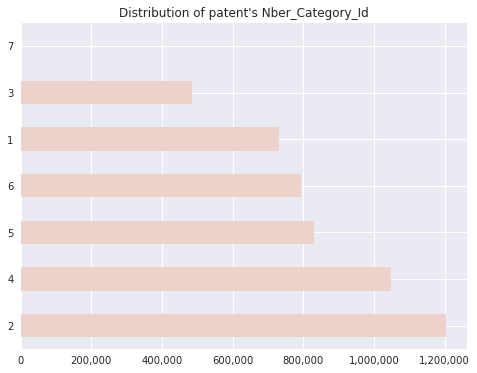

In [13]:
for i in obj_cols:
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.title('Distribution of patent\'s ' + i.title())
    plt.grid(b=True)
    df.groupby(i).count().iloc[:,2].sort_values(ascending=False).head(n=15).plot(ax=ax, kind='barh')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.label.set_visible(False)
    plt.savefig('./img/' + 'barh_' + i +'.png')
    plt.show()
    

In [14]:
df['wipo_field_id']=df['wipo_field_id'].apply('{:0>2}'.format)

In [15]:
# res = pd.crosstab(df.wipo_field_id, df.ipcr_section)
# res = res.div(res.sum(axis=1), axis=0)
# fig, ax = plt.subplots(figsize=(12, 10))
# ax = sns.FacetGrid()
# ax = sns.heatmap(res, annot=False, ax=ax, linewidths=0.5, linecolor='white')
# ax.set_title("Wipo vs IPCR")
# ax.set_yticklabels(rotation=270)

In [16]:
obj_cols

['type',
 'kind',
 'wipo_field_id',
 'ipcr_section',
 'cpc_section_id',
 'nber_category_id']

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


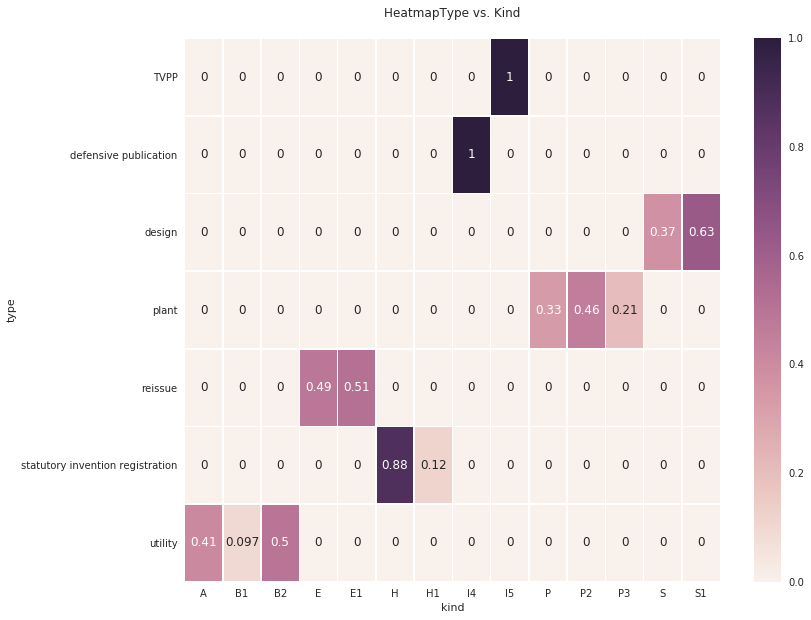

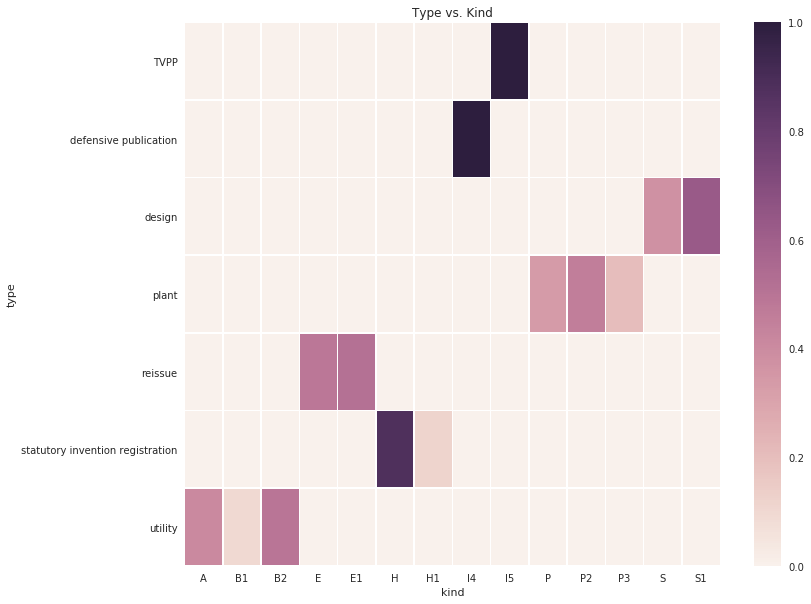

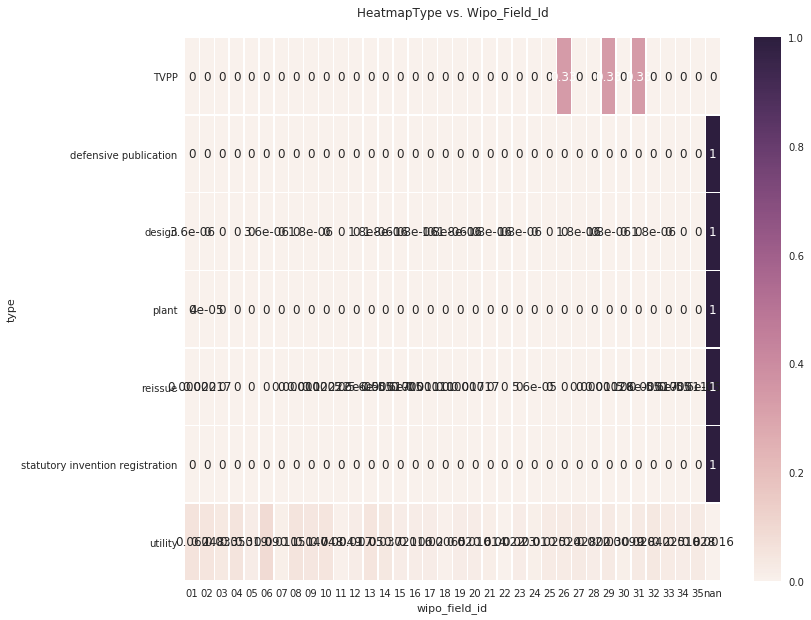

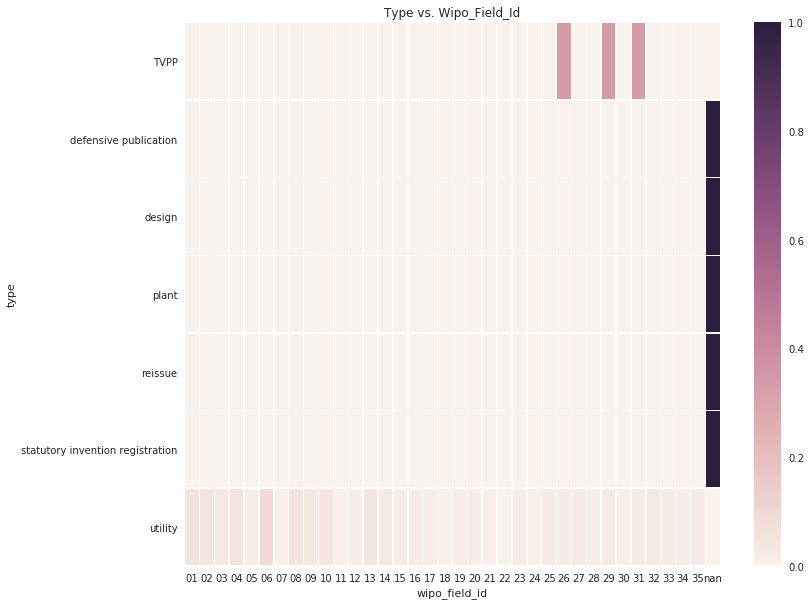

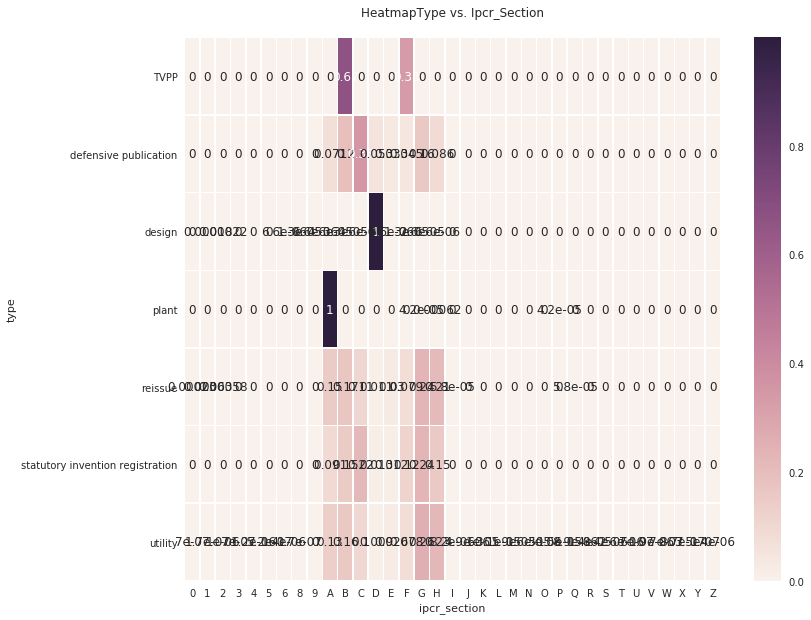

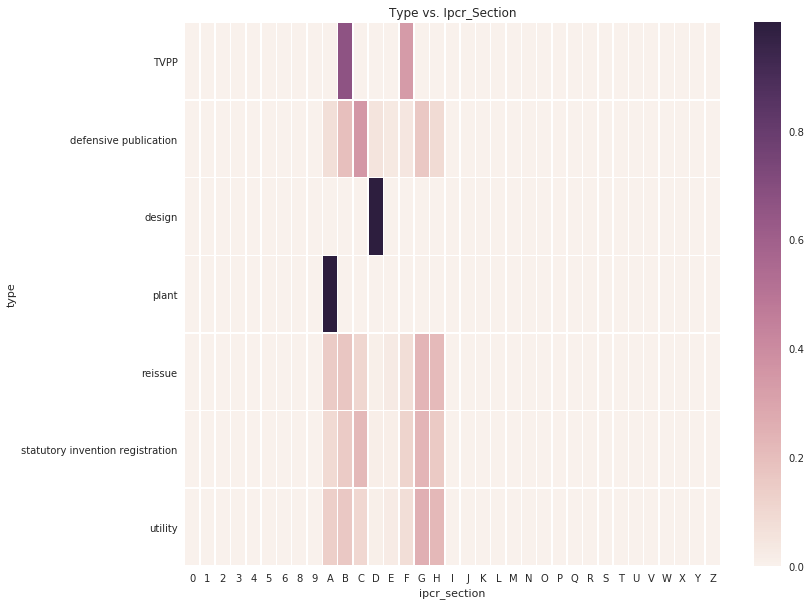

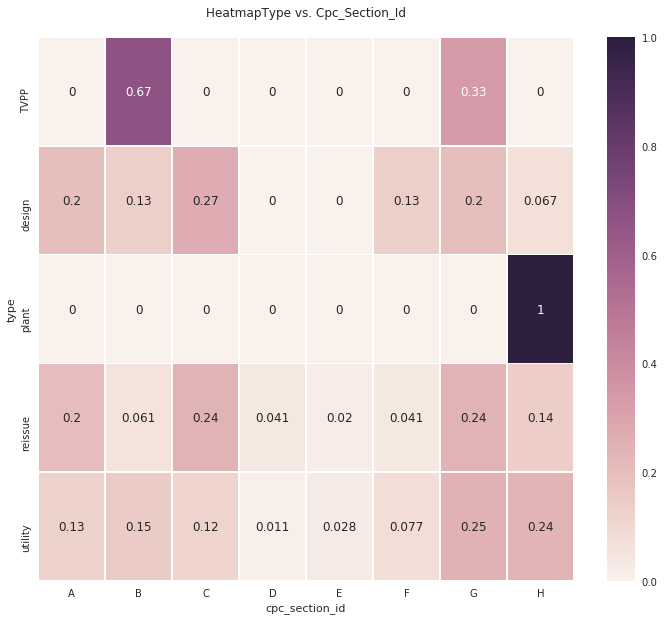

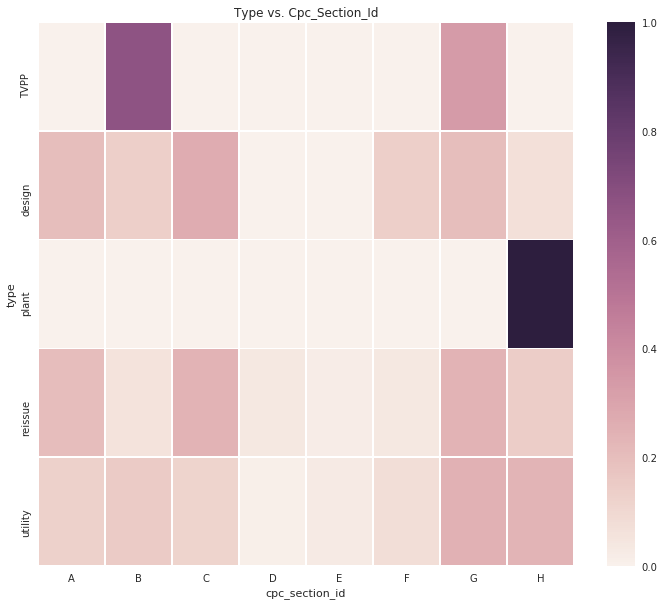

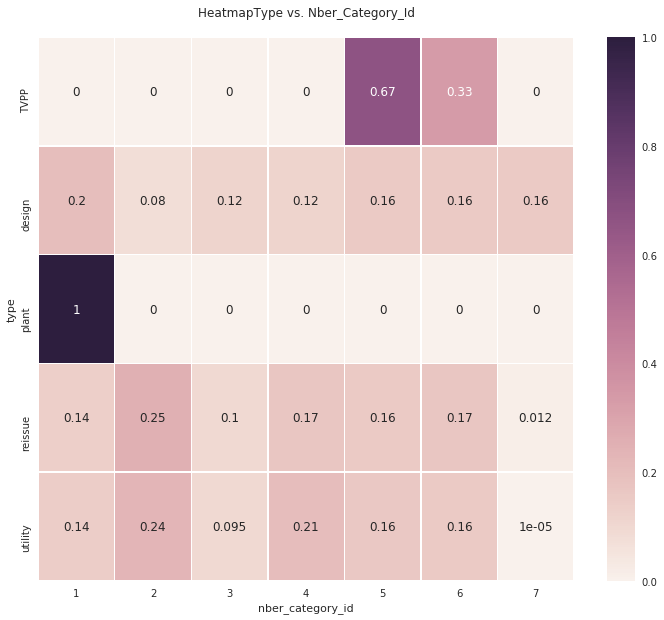

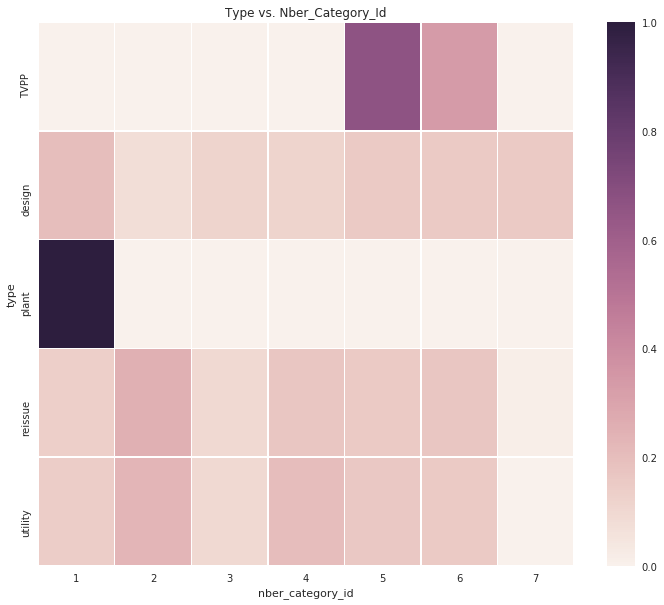

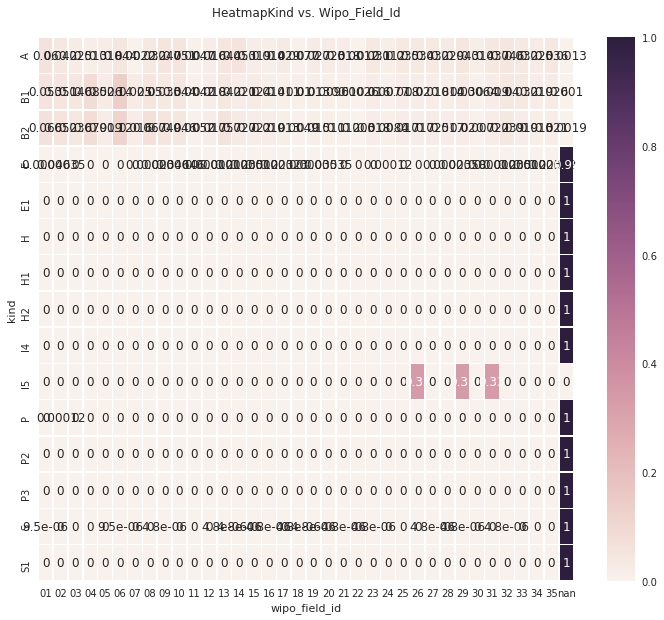

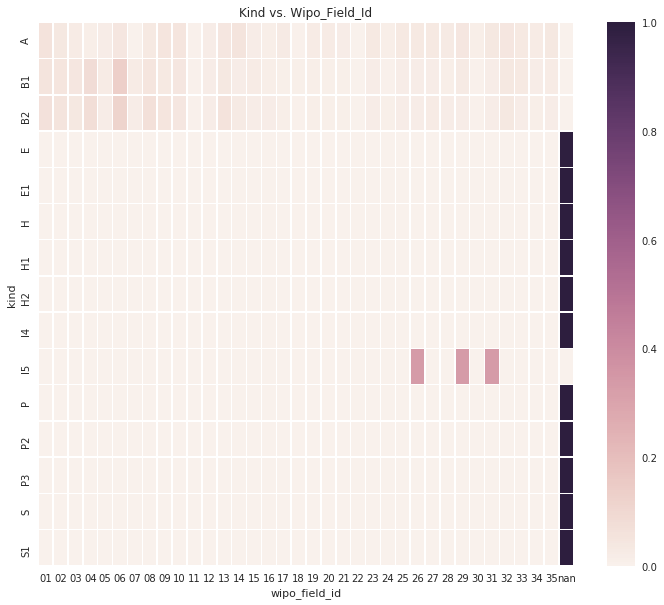

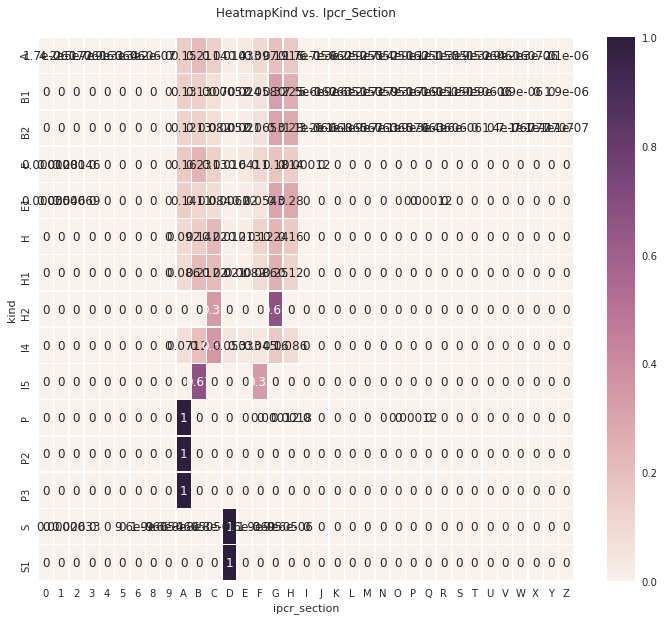

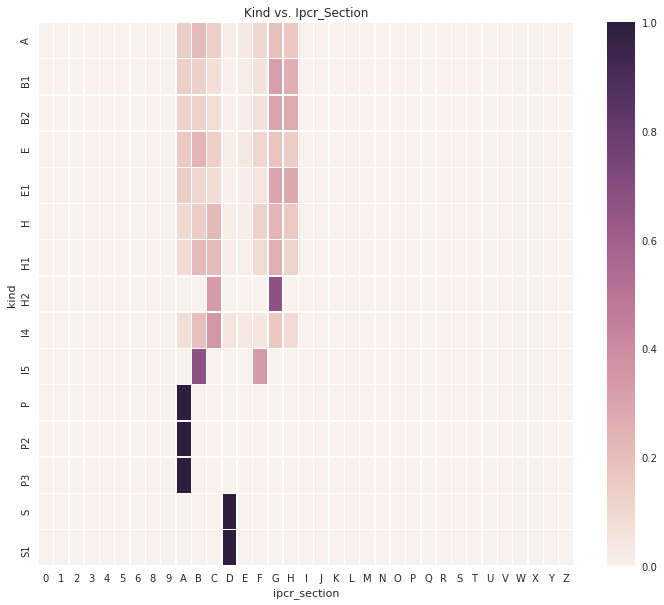

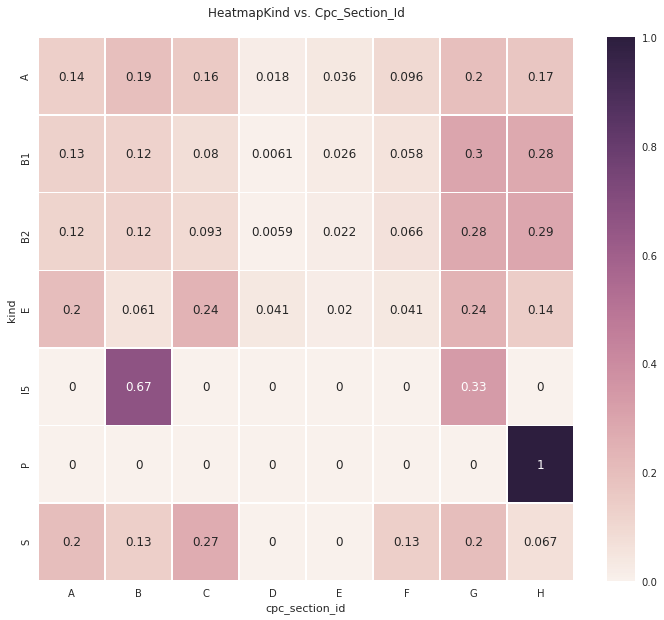

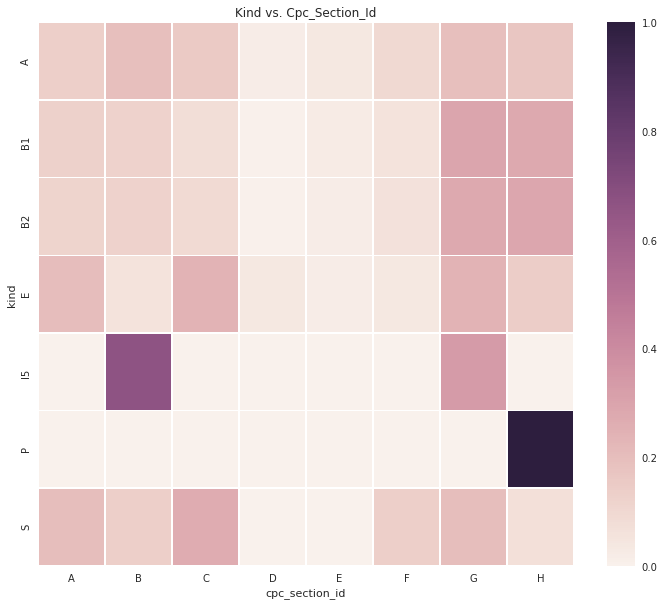

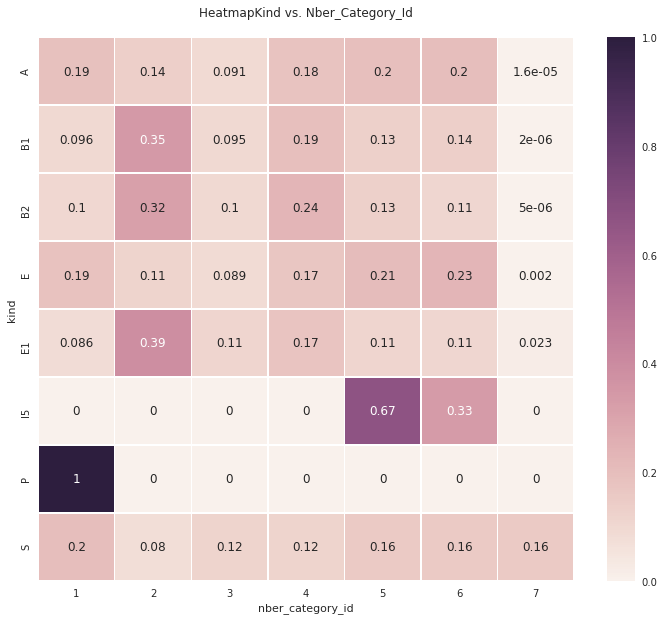

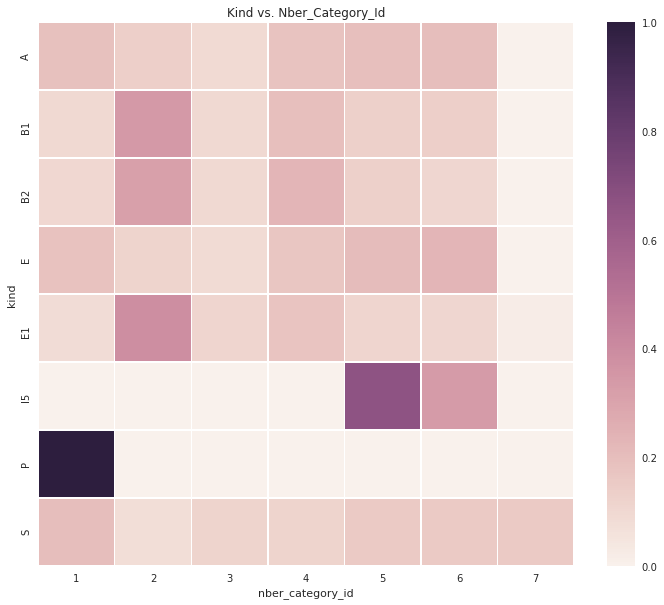

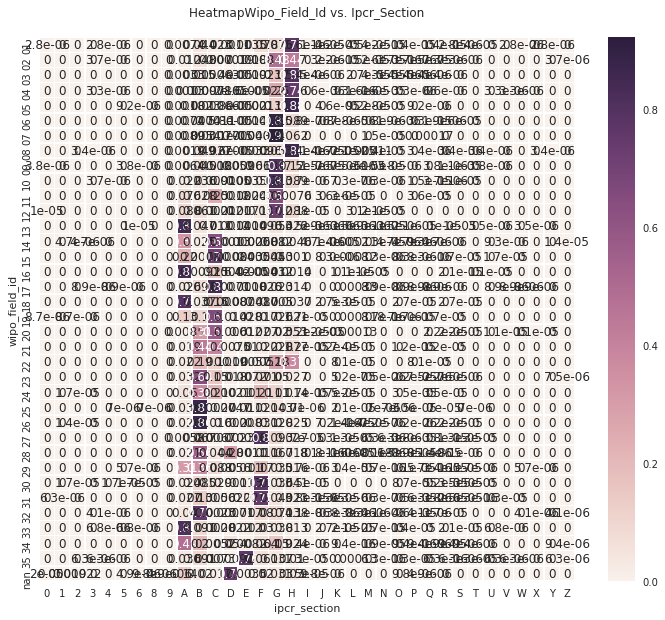

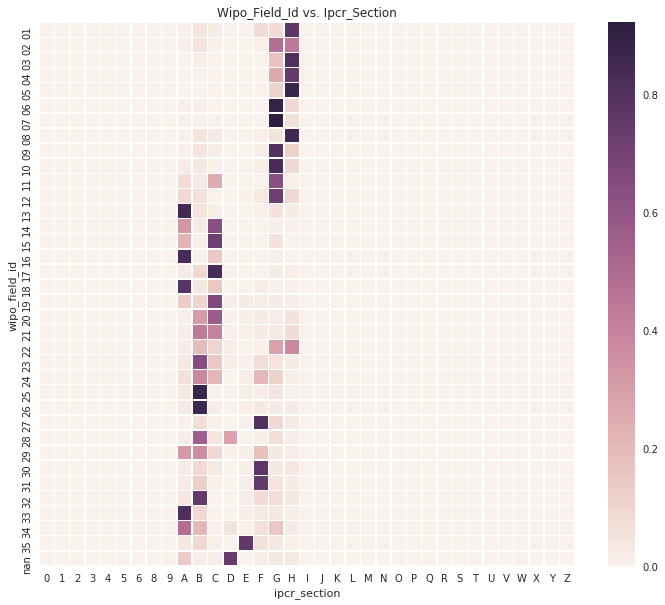

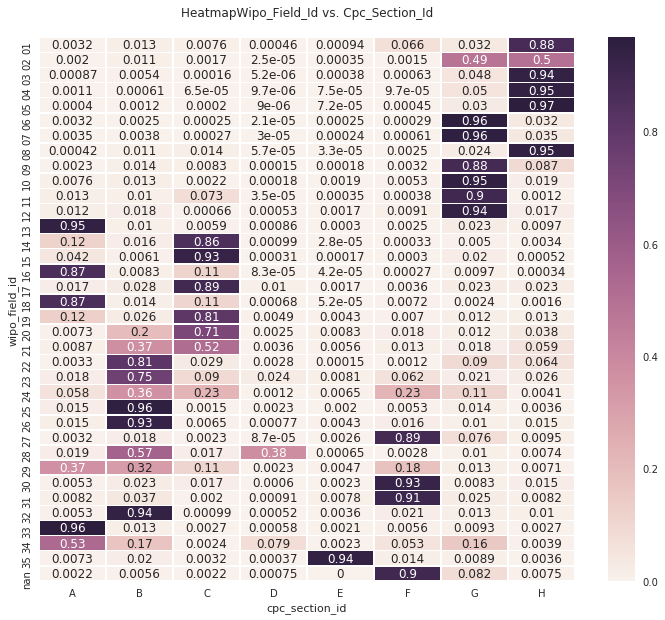

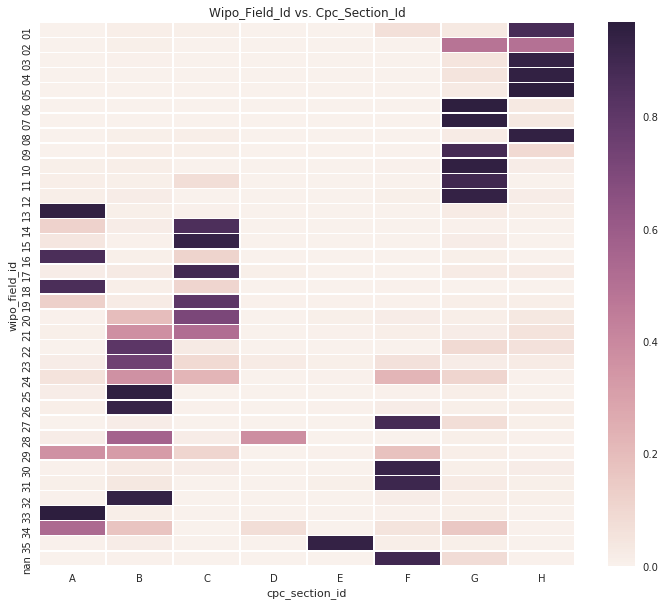

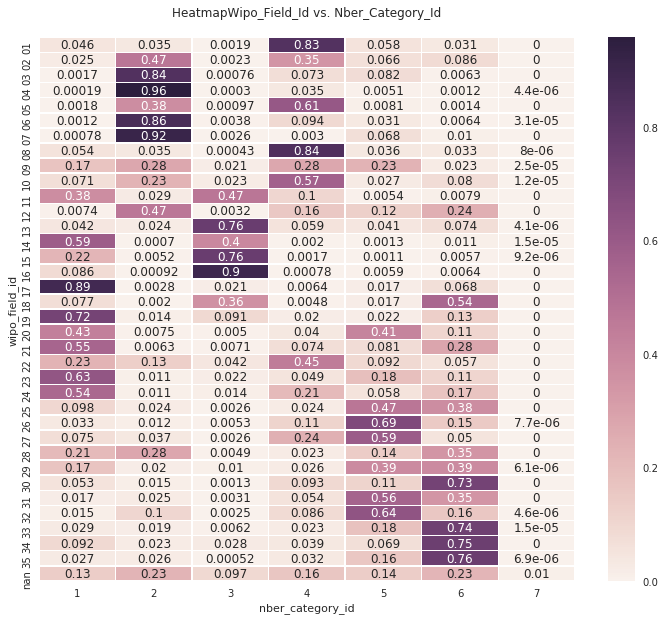

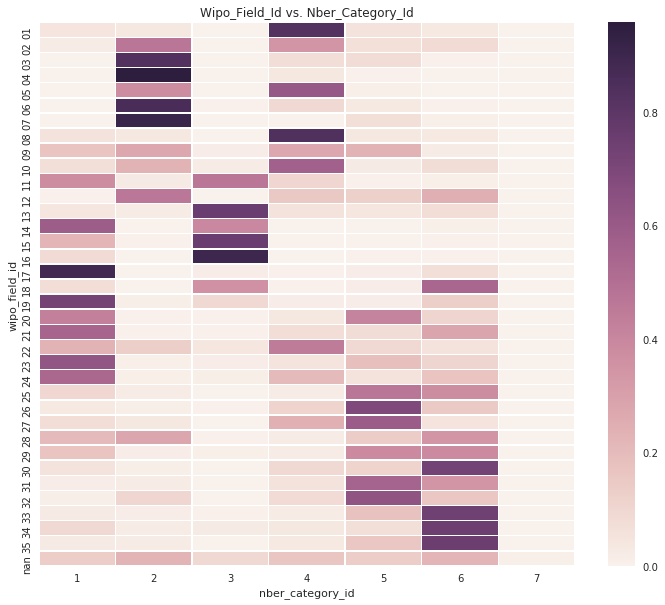

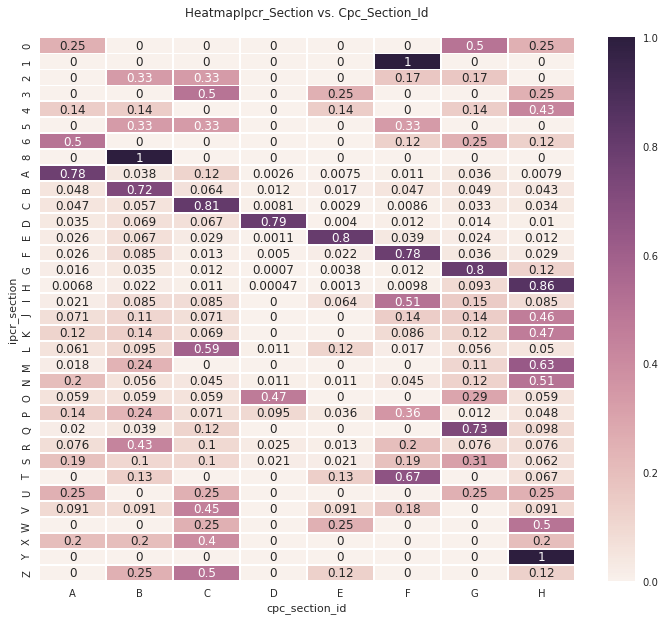

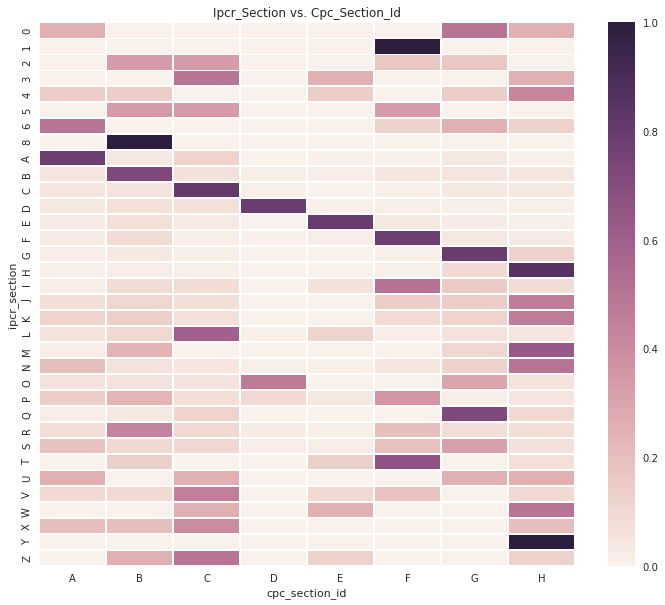

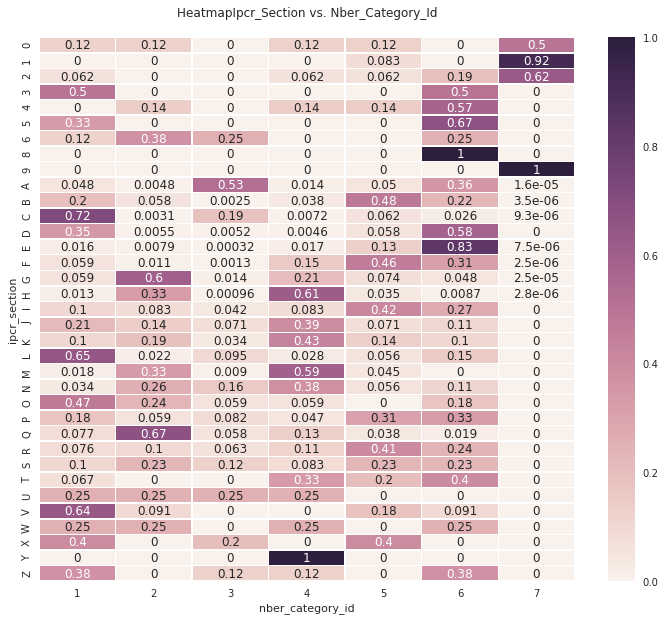

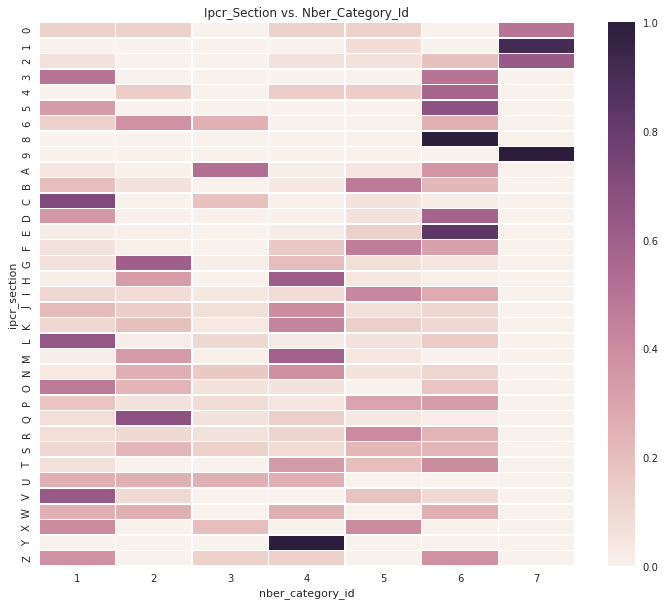

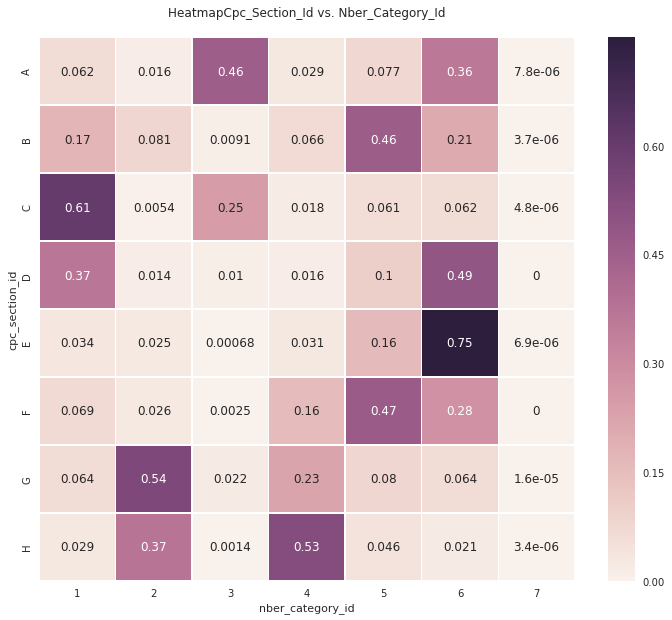

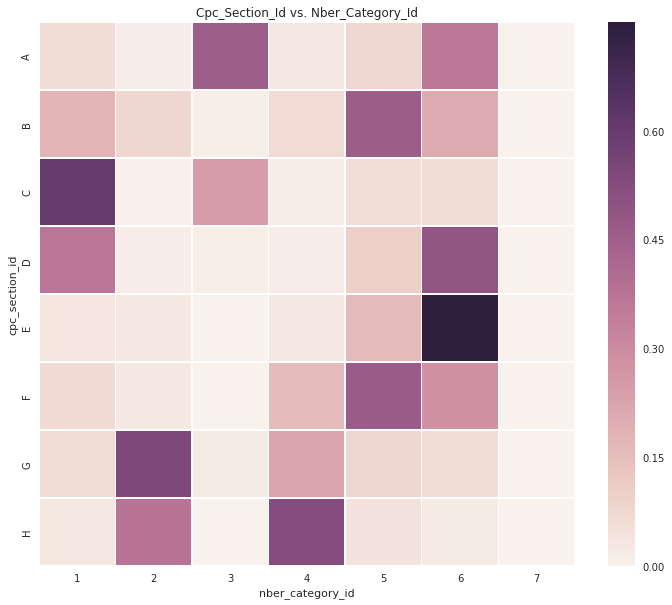

In [17]:
for double in list(itertools.combinations(obj_cols, 2)):
    res = pd.crosstab(df[double[0]], df[double[1]])
    res = res.div(res.sum(axis=1), axis=0)
 
    fig, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(res, annot=True, ax=ax, linewidths=0.5, linecolor='white')
    var1=df[double[0]].name
    var2=df[double[1]].name
    ax.set_title('Heatmap'+var1.title() +' vs. '+ var2.title()+'\n')
    plt.savefig('./img/' + 'heat_' + var1 + '_' + var2 + '_annotated.png')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(res, annot=False, ax=ax, linewidths=0.5, linecolor='white')
    ax.set_title(var1.title() +' vs. '+ var2.title())
    plt.savefig('./img/' + 'heat_' + var1 + '_' + var2 + '.png')

In [18]:
# for double in list(itertools.combinations(obj_cols, 2)):
#     res = pd.crosstab(df[double[0]], df[double[1]])
#     res = res.div(res.sum(axis=1), axis=0)
#     fig, ax = plt.subplots(figsize=(12, 10))
#     ax = sns.heatmap(res, annot=False, ax=ax, linewidths=0.5, linecolor='white', cbar_kws={'fraction' : 0.01})
# #     plt.yticks(rotation=-90)
#     var1=df[double[0]].name
#     var2=df[double[1]].name
#     ax.set_title(var1.title() +' vs. '+ var2.title())
#     plt.savefig('./img/' + 'heat' + var1 + '_' + var2 + '.png')

In [19]:
# an alternative way to calculate the heatmap
# cramers_v(df['wipo_field_id'], df['ipcr_section'])
# output=df[obj_cols].corr(method=cramers)
# sns.heatmap(output)
# plt.imshow(output, cmap='hot', interpolation='nearest')
# plt.show()

In [20]:
# normalization
# df=normalize(df)

In [21]:
# #maybe nb fit does not accept nomalized data, so i using data without normalize
# #but in that case, i have to transform the categorical variables

# obj_cols=list(df.select_dtypes(include=[object]).columns.values)

# for col in obj_cols:
#     df[col] = df[col].astype('category')

# df=pd.get_dummies(df, columns=obj_cols, prefix=obj_cols)

In [22]:
# # List of IVs
# chosenColumns=df.columns.values.tolist()
# len(chosenColumns)

In [23]:
# # chosenColumns.remove(['back_citation'])
# len(chosenColumns)

# # chosenColumns.remove(['parent_back_citation'])
# # len(chosenColumns)

# # chosenColumns.remove('citation_bi')
# # chosenColumns.remove('log_back_cit')

# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['back_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# # testSize = yTest.shape[0]
# # trainSize = yTrain.shape[0]

In [24]:
# best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

In [25]:
# This selector does not work because almost every attribute is p-value significant

# selector = SelectKBest(f_classif, k=4) #initialize 
# selector.fit(myX, myY) #fit
# scores = -np.log10(selector.pvalues_) #transform pvalues (why?)
# scores /= scores.max() #normalize 
# plt.bar(myX - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
#         edgecolor='black')

In [26]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [27]:
# #Let's do something else
# #Change the DV 

# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['parent_back_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 

In [28]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [29]:
# df.parent_back_citation.boxplot()

In [30]:
#and graphs of back citation in time